In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import scipy.stats as sp
import matplotlib as mtp

In [2]:
# parameter for plots
figDir = "/cellar/users/a53206221/Data/PQ3RO1/fig/update.7.6.2020/"
mtp.rcParams['pdf.fonttype'] = 42

# PARAMETERS

In [3]:
# order of the chromosome index
order_index = []
for i in range(1,23):
    for arm in ["p","q"]:
        order_index.append(str(i) + arm)
order_index.extend(["Xp","Xq"])

# COLOR CODE

In [4]:
CMAP_GRAY = [(0.8,0.8,0.8),
             (0.1,0.1,0.1)] # The Gray and Black cmap
CMAP_WHITE = [(0.95,0.95,0.95),
             (0.6,0.6,0.6)]
CMAP_WHITE_R = [(0.6,0.6,0.6),
               (0.95,0.95,0.95)]

# LOAD GENE SET

In [5]:
Dir = "/cellar/users/a53206221/Data/REACTOME/"
import os

dict_f = {}
dict_gene = {}
files = os.listdir(Dir)
for f in files:
    if f != ".ipynb_checkpoints":
        dict_f[f] = pd.read_csv(Dir + f,sep = '\t')
        dict_gene[f.split("_")[0]] = [x.split()[1] for x in dict_f[f]["MoleculeName"]]
        
dict_gene["PERK"].remove("IL8")
dict_gene["PERK"].append("CXCL8")

dict_gene["XBP1S"].remove("ATPV0D1")
dict_gene["XBP1S"].append("ATP6V0D1")

dict_gene["XBP1S"].remove("C19orf10")
dict_gene["XBP1S"].append("MYDGF")

dict_gene["XBP1S"].remove("SRPR")
#dict_gene["XBP1S"].append("SPRPA")

dict_gene["IRE1alpha"].remove("SRPR")
#dict_gene["XBP1S"].append("SPRPA")

dict_gene["IRE1alpha"].remove("ATPV0D1")
dict_gene["IRE1alpha"].append("ATP6V0D1")

dict_gene["IRE1alpha"].remove("Xbp1")
dict_gene["IRE1alpha"].remove("Xbp1")
dict_gene["IRE1alpha"].append("XBP1")

dict_gene["IRE1alpha"].remove("C19orf10")
dict_gene["IRE1alpha"].append("MYDGF")

uprGene = []
for i in range(len(dict_gene.values())):
    uprGene.extend(dict_gene.values()[i])
    
uprGene = list(set(uprGene)) # remove duplicates

# Load Data

In [6]:
tcgaDf = pd.read_csv("/cellar/users/a53206221/Data/Expression/TCGA_TP_allgene.csv")

# compute SCNA score & Figure 1 (Pan-cancer distribution of SCNA)

In [7]:
SCNADf = pd.read_csv("/cellar/users/a53206221/Data/PQ3RO1/SCNADf_v3.tsv",sep = '\t')
SCNADf.drop("Unnamed: 0",axis = 1,inplace=True)

In [8]:
armSignature = pd.read_csv("/cellar/users/a53206221/Data/PQ3RO1/armInensity_updated.csv", index_col = 0)

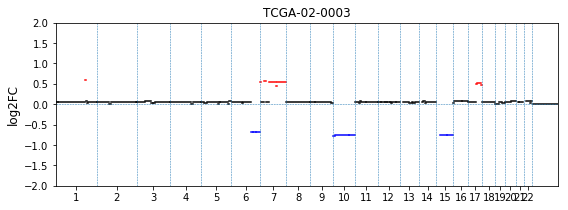

In [9]:
"""Figure 1.B"""
chr_baselength = pd.read_csv("/cellar/users/a53206221/Data/SCNA/chromosomeArmPositionHg38.tsv",sep='\t')

tmp = pd.read_csv("/cellar/users/a53206221/Data/GDC_CNVdata/TCGA-02-0003_TUMOR.seg.txt.bed",sep='\t',header=None)
tmp.columns = ['chromosome','start','end','number of markers','log2FC']
tmp.set_index('chromosome',inplace=True)
chroindex = [ str(x) for x in range(1,23)] + ['X']
accum = 0
accumlist = []

ampthreshold = np.log2(1.1)
delthreshold = np.log2(0.9)
ampthreshold_H = 1
delthreshold_H = -1

"""loading data and preparation end"""

for i in range(1,len(chroindex)):
    accum = accum + np.int(chr_baselength[chr_baselength['chromosome'] == chroindex[i-1]].chromEnd.values)
    accumlist.append(accum)
    try:
        tmp.loc[chroindex[i],['start']] = tmp.loc[chroindex[i],['start']] + accum
        tmp.loc[chroindex[i],['end']] = tmp.loc[chroindex[i],['end']] + accum
    except ValueError:
        continue
        
"""get accumulation of index end"""

tmp['category'] = pd.cut(tmp['log2FC'],[-np.inf,delthreshold,ampthreshold,np.inf],labels=['del','norm','amp'])

plt.figure(figsize = (9,3))
#ax = plt.gca()
tmp.reset_index(inplace= True)
cnorm = tmp[tmp.category == 'norm']
camp = tmp[tmp.category == 'amp']
cdel = tmp[tmp.category == 'del']

g = plt.plot([0, tmp.iloc[0].start],[0,0],color = 'k')# starting line

for chromo in cnorm.chromosome.unique().tolist():
    chr_tmp = cnorm[cnorm.chromosome == chromo]
    for i in range(0,len(chr_tmp)):
        g = plt.plot([chr_tmp.iloc[i].start, chr_tmp.iloc[i].end],[chr_tmp.iloc[i].log2FC,chr_tmp.iloc[i].log2FC],color = 'k')
        #try:
        #    plt.plot([chr_tmp.iloc[i].end, chr_tmp.iloc[i+1].start],[0,0],color = 'k')
        #except IndexError:
        #    continue
        
for chromo in camp.chromosome.unique().tolist():
    chr_tmp = camp[camp.chromosome == chromo]
    for i in range(0,len(chr_tmp)):
        g = plt.plot([chr_tmp.iloc[i].start, chr_tmp.iloc[i].end],[chr_tmp.iloc[i].log2FC,chr_tmp.iloc[i].log2FC],color = 'r')
        
for chromo in cdel.chromosome.unique().tolist():
    chr_tmp = cdel[cdel.chromosome == chromo]
    for i in range(0,len(chr_tmp)):
        g = plt.plot([chr_tmp.iloc[i].start, chr_tmp.iloc[i].end],[chr_tmp.iloc[i].log2FC,chr_tmp.iloc[i].log2FC],color = 'b')
for i in range(0,len(accumlist)):
        plt.axvline(x = accumlist[i],linestyle = '--',linewidth = 0.5)
plt.xlim((0,tmp.end.max()))
plt.ylim((-2,2))
plt.xticks(accumlist - chr_baselength.set_index('chromosome').loc[chroindex]['chromEnd'][0:22]/2,chroindex,fontsize= 10)
plt.title('TCGA-02-0003',fontsize =12)
plt.ylabel('log2FC',fontsize =12)
plt.yticks(fontsize = 10)
plt.axhline(y = 0,linestyle = '--',linewidth = 0.5,xmin = 0, xmax = tmp.end.max())
#plt.savefig("/cellar/users/a53206221/Data/PQ3RO1/fig/SCNAbar/TCGA-02-0003.pdf",bbox_inches='tight')

Text(285.834,0.5,'')

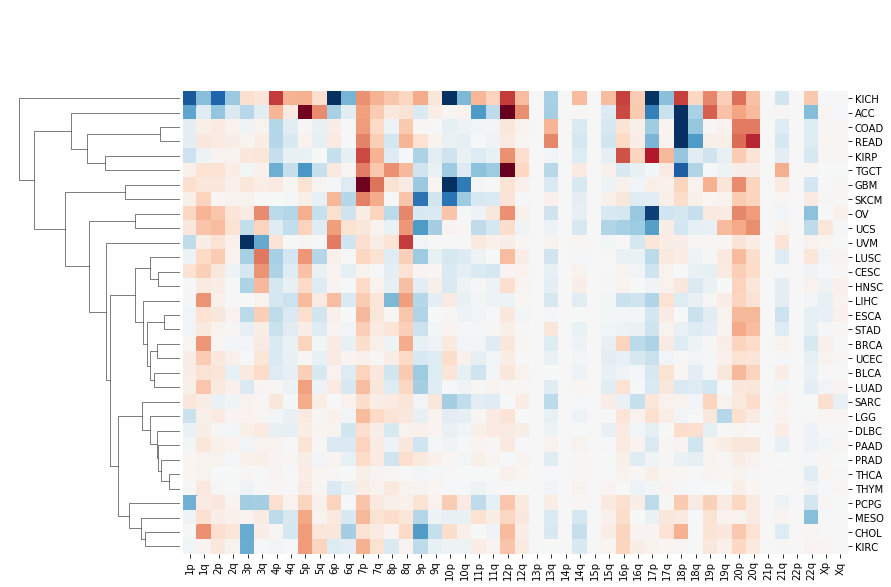

In [10]:
"Figure 1.C"
"""average Signals in different tumor type, signatures of Arm aneuploidy"""
mtp.rc('xtick',labelsize = 10)
mtp.rc('ytick',labelsize = 10)
dfplot = pd.merge(armSignature.reset_index().rename(columns = {"index":"patient_id"}),tcgaDf[["patient_id","disease"]], on = "patient_id")
g = sns.clustermap(dfplot.groupby('disease').mean()[order_index],method = 'ward',
               center = 0,
               cmap = 'RdBu_r',
               vmax = .8,
               vmin = -.8,
               col_cluster = False,
               #row_cluster = False,
               figsize = (15,10),)
#g.ax_heatmap.set_title(disease,fontsize = 20) # show the figure title on top
g.cax.set_visible(False) # do not show colorbar
g.ax_heatmap.set_ylabel('')
#plt.savefig("/cellar/users/a53206221/Data/PQ3RO1/fig/update.6.10.2020/Fig.1C.pdf",bbox_inches = "tight")

In [11]:
dfplot = pd.merge(SCNADf, tcgaDf[["patient_id","disease"]], on = "patient_id").drop_duplicates()

Text(0.5,0,'focal level observation')

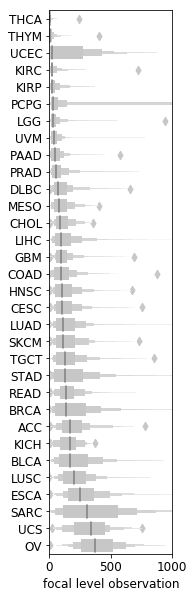

In [12]:
"Figure 1.D Focal SCNA"
plt.figure(figsize = (2.2,10))
aneuploidyType = 'focal'
mtp.rc('xtick',labelsize = 12)
mtp.rc('ytick',labelsize = 12)
index_order = dfplot.groupby('disease')[aneuploidyType].median().sort_values().index.tolist()
g = sns.boxenplot(x = aneuploidyType, 
                  y = 'disease',
                  data = dfplot,
                  order = index_order,
                  color = '#C7C7C7',)
g.set_xlim([0,1000])
g.set_ylabel('')
g.set_xlabel('focal level observation',fontsize = 12)

#g.figure.savefig(figDir + 'focal.pdf',bbox_inches='tight')
#colorCodeWebsite = "https://www.webucator.com/blog/2015/03/python-color-constants-module/"

Text(0.5,0,'focal level observation')

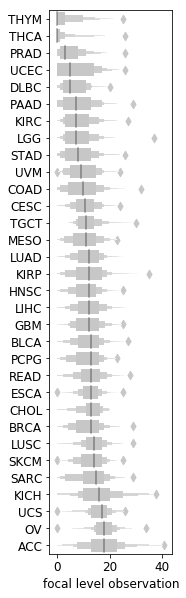

In [13]:
"Figure 1.D Arm SCNA"
plt.figure(figsize = (2.2,10))
aneuploidyType = 'arm'
mtp.rc('xtick',labelsize = 12)
mtp.rc('ytick',labelsize = 12)
index_order = dfplot.groupby('disease')[aneuploidyType].median().sort_values().index.tolist()
g = sns.boxenplot(x = aneuploidyType, 
                  y = 'disease',
                  data = dfplot,
                  order = index_order,
                  color = '#C7C7C7',)
#g.set_xlim([0,1000])
g.set_ylabel('')
g.set_xlabel('focal level observation',fontsize = 12)
#g.figure.savefig(figDir + 'arm.pdf',bbox_inches='tight')
#colorCodeWebsite = "https://www.webucator.com/blog/2015/03/python-color-constants-module/"

Text(0.5,0,'focal level observation')

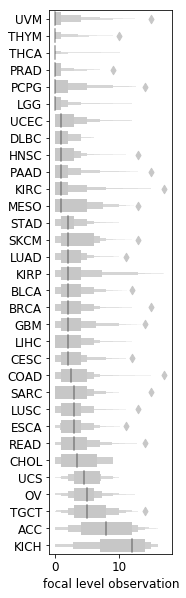

In [14]:
"Figure 1.D Chromosome SCNA"
plt.figure(figsize = (2.2,10))
aneuploidyType = 'chr'
mtp.rc('xtick',labelsize = 12)
mtp.rc('ytick',labelsize = 12)
index_order = dfplot.groupby('disease')[aneuploidyType].median().sort_values().index.tolist()
g = sns.boxenplot(x = aneuploidyType, 
                  y = 'disease',
                  data = dfplot,
                  order = index_order,
                  color = '#C7C7C7',)
#g.set_xlim([0,1000])
g.set_ylabel('')
g.set_xlabel('focal level observation',fontsize = 12)
#g.figure.savefig(figDir + 'chr.pdf',bbox_inches='tight')
#colorCodeWebsite = "https://www.webucator.com/blog/2015/03/python-color-constants-module/"

# A single SCNA score negatively correlates with immune-mediated cytotoxicity  & Figure 2

In [15]:
CMAP_GRAY = [(0.8,0.8,0.8),
             (0.1,0.1,0.1)] # The Gray and Black cmap
CMAP_WHITE = [(0.95,0.95,0.95),
             (0.6,0.6,0.6)]
CMAP_WHITE_R = [(0.6,0.6,0.6),
               (0.95,0.95,0.95)]

In [16]:
#SCNADf = pd.read_csv("/cellar/users/a53206221/Data/PQ3RO1/SCNADf.tsv", sep = '\t')
CYT = pd.read_csv("/cellar/users/a53206221/Data/PQ3RO1/CYT.csv")
stage_info = pd.read_csv("/cellar/users/a53206221/Data/PQ3RO1/stageinfo.csv")
stage_info.columns = ["patient_id","stage"]

In [17]:
tmp = pd.merge(SCNADf,stage_info, on = "patient_id")

'sample saize of SCNA ~ stage'

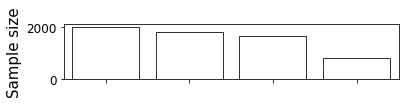

In [18]:
"""Samplesize plot"""
dfplot = pd.DataFrame(tmp.stage.value_counts()).reset_index()
plt.figure(figsize = (6,1))
g = sns.barplot( x = 'index', y = 'stage', data = dfplot,
           facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xlabel('')
plt.ylabel('Sample size',fontsize = 15)
g.axes.set_xticklabels('')
#g.figure.savefig('/cellar/users/a53206221/Data/PQ3RO1/fig/SCNAbar/SCNAvsStageSamplesize.pdf',bbox_inches='tight')
#g.axes.set_yticklabels([0,1000,2000],fontsize =15)
"""sample saize of SCNA ~ stage"""

Text(0,0.5,'SCNA')

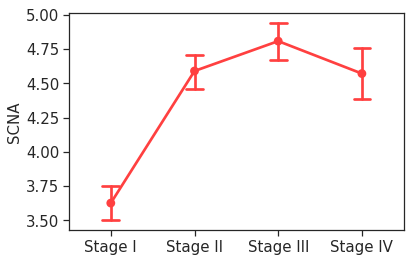

In [19]:
"""Figure 2A"""
tmp = pd.merge(SCNADf,stage_info, on = "patient_id")
#Aneuploidy_total = ['focal','Arm','Chr','A']
sns.set(style="ticks")
mtp.rc('xtick',labelsize = 15)
mtp.rc('ytick',labelsize = 15)
stage_order = ['Stage I','Stage II','Stage III','Stage IV']

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.pointplot(x = "stage", y = "SCNA",data = tmp.drop_duplicates(),
                   order = stage_order,capsize=.2,aspect=.75,color = "#FF4040")
plt.xlabel('')
plt.ylabel('SCNA',fontsize =15)
#g.figure.savefig('/cellar/users/a53206221/Data/PQ3RO1/fig/update.6.10.2020/Fig.2A.pdf',bbox_inches='tight')

Text(0,0.5,'CYT')

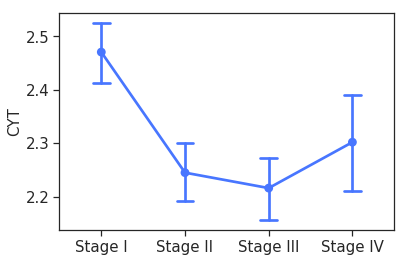

In [20]:
"""Figure 2B"""
sns.set(style="ticks")
mtp.rc('xtick',labelsize = 15)
mtp.rc('ytick',labelsize = 15)
stage_order = ['Stage I','Stage II','Stage III','Stage IV']
# Draw a pointplot to show pulse as a function of three categorical factors
dfplot = pd.merge(CYT,stage_info, on = "patient_id")
g = sns.pointplot(x = "stage", y = "CYT", data = dfplot.drop_duplicates(),
                   order = stage_order,capsize=.2,aspect=.75,color = "#4876FF")
plt.xlabel('')
plt.ylabel('CYT',fontsize = 15)
#g.figure.savefig('/cellar/users/a53206221/Data/PQ3RO1/fig/update.6.10.2020/Fig.2B.pdf',bbox_inches='tight')

Text(0.5,1,'SCNA cor with CYT')

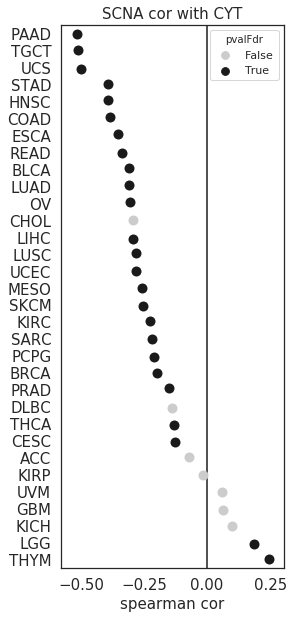

In [21]:
"""C. SCNA cor with CYT"""
dftmp = pd.merge(CYT[['patient_id','CYT']],SCNADf)
dftmp = pd.merge(tcgaDf[["patient_id","disease"]], dftmp, on = "patient_id").drop_duplicates()
from statsmodels.stats.multitest import multipletests
"""CYT cor SCNA"""
corList = []
pvalList = []
for disease in dftmp.disease.unique().tolist():
    tmp = dftmp[dftmp.disease == disease]
    tmp = sp.spearmanr(tmp.SCNA,tmp.CYT)
    corList.append(tmp[0])
    pvalList.append(tmp[1])

dfplot = pd.DataFrame({'cor':corList,
                       'pvalFdr':multipletests(pvalList,method = 'fdr_bh')[0],
                       'disease':dftmp.disease.unique().tolist()})

sns.set_style('white')
mtp.rc('xtick',labelsize = 15)
mtp.rc('ytick',labelsize = 15)
plt.figure(figsize = (4,10))
g = sns.stripplot(x = 'cor', y = 'disease', hue = 'pvalFdr', data = dfplot.dropna().sort_values(by = 'cor'), size = 10,palette = CMAP_GRAY)
plt.axvline(x = 0,color ='k')
plt.xlabel('spearman cor',fontsize = 15)
plt.ylabel('')
plt.title("SCNA cor with CYT",fontsize = 15)
#g.figure.savefig(figDir + 'Fig.2C.pdf',bbox_inches='tight')

# Figure 3

In [22]:
"""Figure 3A"""

'Figure 3A'

In [23]:
"""Measure of the pathway"""
"""Aneuploidy and pathway"""
cor_list = []
pval_list = []
df_cor = pd.DataFrame()
#df_cor_p = pd.DataFrame()
dfmerge = pd.merge(SCNADf[['patient_id','arm','chr','focal','SCNA']],
                   tcgaDf[['EIF2S1','EIF2AK3','DDIT3','ATF6','ERN1','XBP1',"patient_id","disease"]],on='patient_id')
diseaseList = sorted(dfmerge.disease.unique().tolist())
for gene in ['EIF2S1','EIF2AK3','DDIT3','ATF6','ERN1','XBP1']:
    cor_list = []
    pval_list = []
    for disease in diseaseList:
        tmp = sp.stats.spearmanr(dfmerge[dfmerge.disease==disease]['SCNA'],
                                 dfmerge[dfmerge.disease==disease][gene])
        cor_list.append(tmp[0])
        pval_list.append(tmp[1])
    df_cor[gene] = pd.Series(data = cor_list, index = diseaseList)
    df_cor[gene+'pval'] = pd.Series(data = [x > 0.05 for x in pval_list], index = diseaseList)

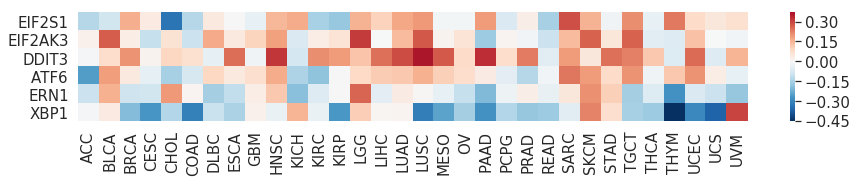

In [24]:
"Figure 3B"
titles=['EIF2S1','EIF2AK3','DDIT3','ATF6','ERN1','XBP1']
plt.figure(figsize = (15,2))
sns.heatmap(df_cor[titles].T,
               center =0,
               cmap = 'RdBu_r',)
#plt.savefig(figDir + "Fig.3B.pdf",bbox_inches='tight')

In [25]:
"Figure 3C preparation, compute the differential expression using Wilcoxon rank-sum test, multiple test correctioni using BH"
from statsmodels.stats.multitest import multipletests

diseaseList = tcgaDf.disease.unique().tolist()
df_ranksum = pd.DataFrame(index = uprGene, columns = diseaseList)
df_pval = pd.DataFrame(index = uprGene, columns = diseaseList)
uprDf = pd.merge(tcgaDf[uprGene + ["patient_id","disease"]],SCNADf[["patient_id","SCNA"]], on = "patient_id")
sampleSize_dict = {}

df_log2FC = pd.DataFrame(index = uprGene, columns = diseaseList)

for disease in diseaseList:
    tmp = uprDf[uprDf.disease == disease]
    l = tmp[tmp.SCNA <= tmp.SCNA.quantile(q = .3)]
    h = tmp[tmp.SCNA >= tmp.SCNA.quantile(q = .7)]
    if disease not in sampleSize_dict.keys():
        sampleSize_dict[disease] = len(l)
    ranksumList = []
    pvalList = []
    
    log2FC = []
    for gene in uprGene:
        # wiolcoxon ranksum test
        test = sp.ranksums(h[gene],l[gene])
        ranksumList.append(test[0])
        pvalList.append(test[1])
        # log2 foldchange of the mean
        log2FC.append(np.log2(np.mean(h[gene])/ np.mean(l[gene])))
    df_log2FC[disease] = pd.Series(index = uprGene, data = log2FC)
    df_ranksum[disease] = pd.Series(index = uprGene, data = ranksumList)
    df_pval[disease] = pd.Series(index = uprGene, data = pvalList)

# multiple test corretion 
multTest = multipletests(pvals=np.ravel(df_pval.values),method = "fdr_bh")
df_fdr = pd.DataFrame(data = multTest[1].reshape(df_ranksum.shape), index = uprGene, columns = df_pval.columns.tolist())

<Figure size 720x576 with 0 Axes>

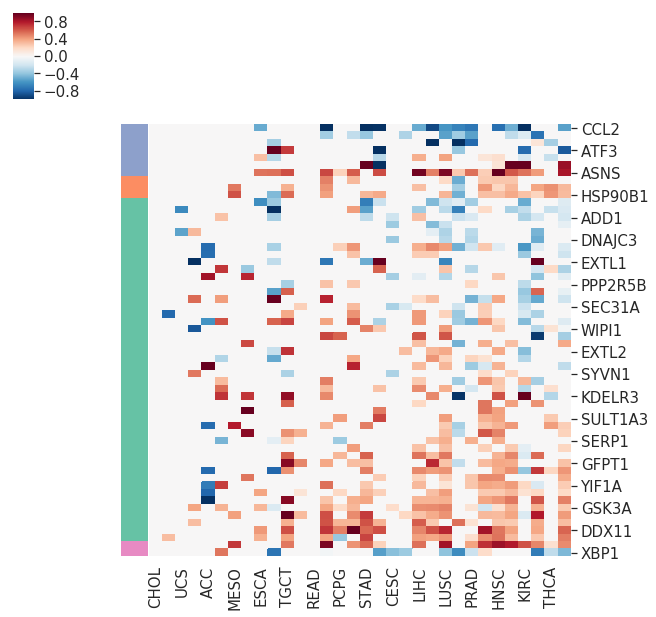

In [26]:
# make the order
order_row_new = []
_mean = df_ranksum.mean(axis = 1)
for path in ["PERK","ATF6","IRE1alpha"]:
    order_row_new.extend(_mean.loc[dict_gene[path]].sort_values().index.tolist())
    
order_row_new.remove("DDIT3")
order_row_new.remove("DDIT3")
order_row_new.remove("XBP1")
order_row_new.remove("XBP1")
order_row_new.extend(["DDIT3","XBP1"])# add to the tail

# set up color for the row
def CreateColorMap(colormap):
    zipList = []
    tmpGeneList = set(dict_gene["IRE1alpha"] + dict_gene["PERK"] + dict_gene["ATF6"])
    for gene in tmpGeneList:
        if gene == "XBP1" or gene == "DDIT3":
            zipList.append(colormap[3]) # overlapping genes
        elif gene in dict_gene["IRE1alpha"]:
            zipList.append(colormap[0])
        elif gene in dict_gene["PERK"]:
            zipList.append(colormap[2])
        elif gene in dict_gene["ATF6"]:
            zipList.append(colormap[1])
    return dict(zip(tmpGeneList,zipList))
r_color = CreateColorMap(sns.color_palette("Set2")[:4])

# start to plot
plt.figure(figsize = (10,8))
order = pd.DataFrame({"n":sampleSize_dict}).sort_values(by = "n").index.tolist()
# adjust disease order in the columns
ax = sns.clustermap(df_log2FC[df_fdr < 0.05].fillna(0).loc[order_row_new][order],
               center = 0,
               cmap = "RdBu_r",
               vmax = 1,
               vmin = - 1,
               #method = "ward",
               col_cluster = False,
               row_cluster = False,
               row_colors = [ r_color[x] for x in order_row_new],
               )
#plt.savefig(figDir + "Fig.3C.pdf",bbox_inches = "tight")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

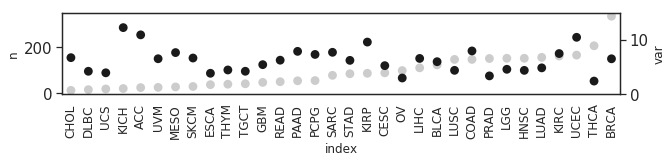

In [27]:
# calcualte the variance
varList = {}
sigNumList = {}
for disease in sampleSize_dict.keys():
    tmp = uprDf[uprDf.disease == disease]
    varList[disease] = np.var(tmp.SCNA)
    sigNumList[disease] = sum(df_fdr[disease] < 0.05)

# a dataframe used to plot
dftmp = pd.DataFrame({"n":sampleSize_dict,
                      "var":varList,
                      "sigGeneNums":sigNumList})

plt.figure(figsize = (10,1.5))
ax = sns.pointplot(x="index", y="n", data = dftmp.reset_index(), join = False, order = order, color = CMAP_GRAY[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, size = 12)
ax2 = ax.twinx()
ax2.set_ylim([0,15])
ax2 = sns.pointplot(x = "index", y="var", data = dftmp.reset_index(), join = False, order = order, color = CMAP_GRAY[1])
#plt.savefig(figDir + "Fig.3Cbottom.pdf",bbox_inches = "tight")

In [28]:
#dftmp.to_csv("/cellar/users/a53206221/Data/PQ3RO1/plot.Fig.S5.csv")

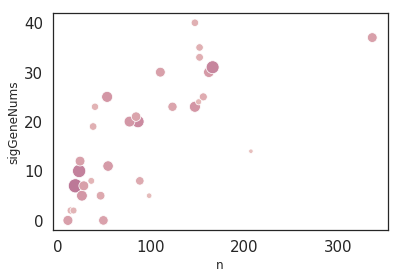

In [29]:
sns.scatterplot(x = "n", y = "sigGeneNums", 
                data = dftmp, size = "var",hue = "var",
                sizes=(20, 200), hue_norm=(0, 30), legend = False)
#plt.savefig(figDir + "Fig.S5.pdf",bbox_inches = "tight")

In [30]:
sp.stats.spearmanr(dftmp["sigGeneNums"],
                   dftmp["n"])

SpearmanrResult(correlation=0.7715471302438686, pvalue=2.3487116156485468e-07)

# Figure 4 Differential coexpression analysis

In [31]:
"""go use the old SCNA score since we have 0.999 cor and due to the random seed it is hard to reproduce this"""

'go use the old SCNA score since we have 0.999 cor and due to the random seed it is hard to reproduce this'

In [32]:
Dir = "/cellar/users/a53206221/Data/PQ3RO1/difcoexpUpdate.7.6.2020/"

difffile=[ Dir + x for x in os.listdir(Dir) if "csv"in x]
diff_dict={}
for f in difffile:
    d = f.split(".")[3].split("/")[-1]
    if d in diseaseList:
        diff_dict[d]=pd.read_csv(f,index_col=0)
    
# UPR differential coexp data 

In [33]:
# calculate total count for all 31 disease
df_pairs = pd.DataFrame(index=uprGene,columns=uprGene,data = np.zeros([len(uprGene),len(uprGene)]))
df_pairs = df_pairs.stack().reset_index()
df_pairs.rename(columns ={0:'count'},inplace=True)

for disease in diff_dict.keys():
    t= ((diff_dict[disease]<50)+0) -np.diag(np.diag(((diff_dict[disease]<50)+0)))
    t= t.stack().reset_index()
    t.rename(columns = {0:'count'},inplace=True)
    df_pairs['count'] += t['count']

In [34]:
"Load the differential coexpression data after permutation test"
#df_pairs.to_csv("/cellar/users/a53206221/Data/PQ3RO1/difcoexpUpdate.7.6.2020/df_perturbation_pairs.csv")
# UPR differential coexp data 

'Load the differential coexpression data after permutation test'

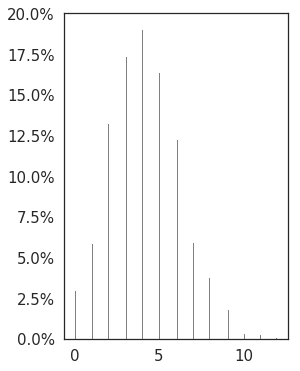

In [35]:
"Figure 4B"
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(4,6))
plt.hist(df_pairs['count'].values.astype(np.int),bins=100,weights=np.ones(len(df_pairs)) / len(df_pairs),color="gray")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.savefig(figDir + "Fig.4B.pdf",bbox_inches='tight')

In [36]:
# calculate total count for all 32 disease
df_pairswise = pd.DataFrame(columns=['level_0','level_1','pval','corr','disease'])

for disease in diff_dict.keys():

    t = (diff_dict[disease]/np.float(1000)).fillna(0).stack().reset_index()
    t.rename(columns = {0:'pval'},inplace=True)

    dfexp = tcgaDf[tcgaDf.disease == disease][['patient_id'] + uprGene]
    dfexp = pd.merge(SCNADf[['SCNA','patient_id']],dfexp,on = 'patient_id')
    dfexplow = dfexp[dfexp.SCNA < dfexp.SCNA.quantile(q=0.3)]
    dfexphigh = dfexp[dfexp.SCNA > dfexp.SCNA.quantile(q=0.7)]

    dfexphigh = dfexphigh[uprGene].corr().stack().reset_index().rename(columns={0:'corr'})
    dfexplow = dfexplow[uprGene].corr().stack().reset_index().rename(columns={0:'corr'})
    t['corr'] = dfexphigh['corr'] - dfexplow['corr']
    t = t[t['pval']<0.05]
    t['disease'] = [disease]*len(t)
    df_pairswise = pd.concat([t,df_pairswise])

[Text(0,0,'0'), Text(0,0,'2000')]

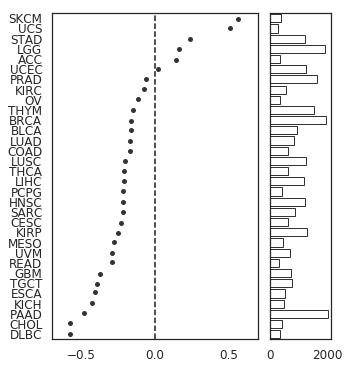

In [37]:
"Figure 4A"
mtp.rc('xtick',labelsize = 12)
mtp.rc('ytick',labelsize = 12)

dftmp = pd.DataFrame({'mean_coexpression_change':df_pairswise[df_pairswise['corr']!=0].groupby('disease')['corr'].median(),
              'number_of_pairwise_gene':df_pairswise[df_pairswise['corr']!=0]['disease'].value_counts()})
#dftmp.drop(["THYM",'THCA'],inplace=True)
#plot this with geneset size 
order = dftmp.sort_values(by='mean_coexpression_change',ascending=False).index.tolist()

fig = plt.figure(figsize=(5, 6))
grid = plt.GridSpec(1, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[0, :3])# column and row location this is
main_ax = sns.stripplot(x = 'mean_coexpression_change',y='index',data=dftmp.reset_index(),order = order,color='.2')
main_ax.axvline(x=0,color='k',linestyle='--')
main_ax.set_xlabel("",fontsize = 12)
main_ax.set_ylabel("",fontsize = 12)
main_ax.set_yticklabels(order,fontsize = 12)
plt.xlim([-.7, .7])
y_plot = fig.add_subplot(grid[0:, 3:], xticklabels=[])
y_plot = sns.barplot(x ='number_of_pairwise_gene',y='index',data=dftmp.reset_index(),
                      order=dftmp.sort_values(by='mean_coexpression_change',ascending=False).index.tolist(),
                      color='white',edgecolor=".2")
y_plot.set_yticklabels([],fontsize = 12)
y_plot.set_ylabel("",fontsize = 12)
y_plot.set_xlabel("",fontsize = 12)
y_plot.set_xticklabels([0,2000],fontsize = 12)

#plt.savefig(figDir + "Fig.4A.pdf",bbox_inches='tight')

In [38]:
#df_pairswise.to_csv("/cellar/users/a53206221/Data/PQ3RO1/difcoexpUpdate.7.6.2020/df_perturbation_pairswise.csv")

In [39]:
t = df_pairs[df_pairs['count'] >= 9]
tmplogic = [False]*len(df_pairswise)
for x,y in zip(t.level_0,t.level_1):
    tmp = [(t1 == x) and (t2 == y) for t1,t2 in zip(df_pairswise.level_0,df_pairswise.level_1)]
    tmplogic = [l1 or l2 for l1,l2 in zip(tmplogic,tmp)]

dftmp = df_pairswise[tmplogic]
dftmp['hue'] = [ x+'-'+y for x,y in zip(dftmp['level_0'].tolist(),dftmp['level_1'].tolist())]

/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
tmplist = [ np.sort([x.split("-")[0],x.split("-")[1]])[0]+"-"+ np.sort([x.split("-")[0],x.split("-")[1]])[1] for x in dftmp['hue'].tolist() ]
dftmp['hue_ordered'] = tmplist
dftmp['-log10pval'] = [-np.log(x+0.001) for x in dftmp.pval]

/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,0,'')

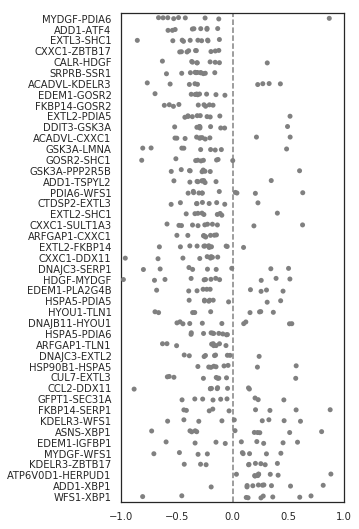

In [41]:
mtp.rc('xtick',labelsize = 10)
mtp.rc('ytick',labelsize = 10)
plt.figure(figsize=(4,9))
order = dftmp.drop_duplicates(subset=['corr','hue_ordered']).groupby('hue_ordered')['corr'].median().sort_values().index.tolist()
sns.stripplot(x='corr',y='hue_ordered',data=dftmp.drop_duplicates(subset=['corr','hue_ordered']),color='gray',order=order,)
plt.axvline(x=0,color='gray',linestyle='--')
plt.xlim([-1,1])
plt.ylabel("")
plt.xlabel("")
#plt.savefig(figDir + "Fig.4C.pdf",bbox_inches='tight')

In [42]:
len(df_pairs[df_pairs["count"] >= 9]) / float(len(df_pairs))

0.0267538644470868

In [43]:
perturbed_gene_pairs = dftmp.groupby("hue_ordered")["corr"].median()[dftmp.groupby("hue_ordered")["corr"].median()< 0].index.tolist()
perturbed_genes = set()
for pairs in perturbed_gene_pairs:
    pairs = pairs.split("-")
    perturbed_genes.add(pairs[0])
    perturbed_genes.add(pairs[1])
#saveDir = "/cellar/users/a53206221/Data/PQ3RO1/difcoexpUpdate.6.10.2020/perturbed_gene_list.txt"
#with open(saveDir,"w") as f:
#    for line in perturbed_genes:
#        f.write(line + "\n")

In [44]:
gene_counts = {}
for gene_pair in perturbed_gene_pairs:
    genes = gene_pair.split("-")
    for gene in genes:
        if gene in gene_counts.keys():
            gene_counts[gene] += 1
        else:
            gene_counts[gene] = 1

In [45]:
gene_counts

{'ACADVL': 2,
 'ADD1': 2,
 'ARFGAP1': 2,
 'ATF4': 1,
 'CALR': 1,
 'CCL2': 1,
 'CTDSP2': 1,
 'CUL7': 1,
 'CXXC1': 5,
 'DDIT3': 1,
 'DDX11': 2,
 'DNAJB11': 1,
 'DNAJC3': 2,
 'EDEM1': 2,
 'EXTL2': 4,
 'EXTL3': 3,
 'FKBP14': 3,
 'GFPT1': 1,
 'GOSR2': 3,
 'GSK3A': 3,
 'HDGF': 2,
 'HSP90B1': 1,
 'HSPA5': 3,
 'HYOU1': 2,
 'KDELR3': 1,
 'LMNA': 1,
 'MYDGF': 2,
 'PDIA5': 2,
 'PDIA6': 3,
 'PLA2G4B': 1,
 'PPP2R5B': 1,
 'SEC31A': 1,
 'SERP1': 2,
 'SHC1': 3,
 'SRPRB': 1,
 'SSR1': 1,
 'SULT1A3': 1,
 'TLN1': 2,
 'TSPYL2': 1,
 'WFS1': 1,
 'ZBTB17': 1}

In [46]:
for gene in perturbed_genes:
    print gene

CCL2
FKBP14
ACADVL
ADD1
EDEM1
HSP90B1
ARFGAP1
SEC31A
ZBTB17
HSPA5
WFS1
DDX11
TLN1
DNAJB11
CUL7
PDIA5
CTDSP2
DDIT3
SHC1
TSPYL2
PDIA6
EXTL2
EXTL3
SULT1A3
SERP1
KDELR3
PLA2G4B
LMNA
HDGF
CALR
HYOU1
GSK3A
DNAJC3
SSR1
CXXC1
MYDGF
GOSR2
ATF4
GFPT1
PPP2R5B
SRPRB


In [47]:
"""Fig 4.D prepare .csv file for cytoscape"""
augmented_pairs = pd.DataFrame(dftmp.groupby("hue_ordered")["corr"].median()[dftmp.groupby("hue_ordered")["corr"].median() > 0])

In [48]:
s = set()
for pairs in augmented_pairs.index.tolist():
    pairs = pairs.split("-")
    s.add(pairs[0])
    s.add(pairs[1])

In [49]:
for x in s:
    print x

HERPUD1
ZBTB17
ADD1
ASNS
IGFBP1
MYDGF
EDEM1
KDELR3
ATP6V0D1
WFS1
XBP1


In [50]:
Dir = "/cellar/users/a53206221/Data/PQ3RO1/conserved_gene_pairs.txt"
with open(Dir,"r") as f:
    conserved_gene_pairs = f.read()
conserved_gene_pairs = conserved_gene_pairs.split("\n")[:-1]

In [51]:
conserved_counts = {}
for genePairs in conserved_gene_pairs:
    genes = genePairs.split("-")
    for gene in genes:
        if gene not in conserved_counts.keys():
            conserved_counts[gene] = 1
        else:
            conserved_counts[gene] += 1

In [52]:
dict_allCounts = {}
dict_allCounts.update(conserved_counts)
for k in gene_counts.keys():
    if k in dict_allCounts.keys():
        dict_allCounts[k] += gene_counts[k]
    else:
        dict_allCounts[k] = 1
        
for genePairs in augmented_pairs.index.tolist():
    genes = genePairs.split("-")
    for gene in genes:
        if gene not in dict_allCounts.keys():
            dict_allCounts[gene] = 1
        else:
            dict_allCounts[gene] += 1

In [53]:
sourceList = []
targetList = []
valueList = []
symbolList = []
for genepair in perturbed_gene_pairs:
    s, t = genepair.split("-")
    sourceList.append(s)
    targetList.append(t)
    valueList.append(dict_allCounts[s])
    symbolList.append("perturbed")
    
for genepair in conserved_gene_pairs:
    s, t = genepair.split("-")
    sourceList.append(s)
    targetList.append(t)
    valueList.append(dict_allCounts[s])
    symbolList.append("conserved")

for genepair in augmented_pairs.index.tolist():
    s, t = genepair.split("-")
    sourceList.append(s)
    targetList.append(t)
    valueList.append(dict_allCounts[s])
    symbolList.append("augmented")

In [54]:
len(perturbed_gene_pairs) + len(augmented_pairs)

45

In [55]:
dfplot = pd.DataFrame({"source" : sourceList,
                      "target" : targetList,
                      "interaction": ["dd"] * len(sourceList),
                      "directed" : ["FALSE"] * len(sourceList),
                      "symbol" : symbolList,
                      "value": valueList})

In [56]:
#dfplot.to_csv("/cellar/users/a53206221/Data/PQ3RO1/network_file.csv")

In [57]:
upr_membership = {}
for source in dict_allCounts.keys():
    if source == "DDIT3":
        upr_membership[source] = "Overlap"
    elif source in dict_gene["PERK"]:
        upr_membership[source] = "PERK"
    elif source in dict_gene["ATF6"]:
        upr_membership[source] = "ATF6"
    elif source in dict_gene["IRE1alpha"]:
        upr_membership[source] = "IRE1a"
        
dfmark = pd.DataFrame({"pathway":upr_membership}).reset_index()
dfmark.rename(columns = {"index" : "gene"},inplace = True)
#dfmark.to_csv("/cellar/users/a53206221/Data/PQ3RO1/network_file_mark.csv")

In [58]:
df_pairswise[[ x == "ATF4" and y == "DDIT3" for x,y in zip(df_pairswise.level_0, df_pairswise.level_1)]]

,level_0,level_1,pval,corr,disease
3158,ATF4,DDIT3,0.038,-0.231551,BRCA
3158,ATF4,DDIT3,0.024,0.227904,KIRP
3158,ATF4,DDIT3,0.001,-0.424147,THYM
3158,ATF4,DDIT3,0.005,-0.145701,HNSC
3158,ATF4,DDIT3,0.000,-0.402913,THCA
3158,ATF4,DDIT3,0.000,-0.295469,UCEC


# Figure 5

In [59]:
pathwayScore = pd.read_csv("/cellar/users/a53206221/Data/PQ3RO1/pathwayScoreDf.csv")

In [60]:
def plotCorrelation(df, var, saveFig = False, saveDir = None):
    """plot correlation
    @df the dataframe as input;
    @var the correlation variable, SCNA or CytoSolicAC;
    """
    
    dict_fig5 = {}

    for pathway in ["PERK","ATF6","XBP1S","RIDD"]:
        corList, pvalList = [], []
        for disease in df.disease.unique().tolist():
            tmpplot = df[df.disease == disease].dropna(subset = [var])
            cor, pval = sp.spearmanr(tmpplot[var],tmpplot[pathway])
            corList.append(cor)
            pvalList.append(pval)
        dict_fig5[pathway] = pd.DataFrame({"disease":df.disease.unique().tolist(),
                                           "spearmanr":corList,
                                           "pval":pvalList})
        dict_fig5[pathway].dropna(inplace = True)
        multTest = multipletests(pvals = dict_fig5[pathway]['pval'].tolist(), method = "fdr_bh")
        dict_fig5[pathway]["sig"] = multTest[0]
        dict_fig5[pathway]["fdr"] = multTest[1]

    for path in dict_fig5.keys():
        plt.figure(figsize = (3,7))
        plt.title(path)
        sns.stripplot(x = "spearmanr",
                      y = "disease",
                      size = 8,
                      hue = "sig",
                      order = dict_fig5[path].sort_values(by = "spearmanr")["disease"].tolist(),
                      data = dict_fig5[path],
                      palette = CMAP_GRAY)
        plt.axvline(x = 0, color = "k",linestyle = "--")
        if saveFig:
            plt.savefig(saveDir + path + "." + var + ".pdf",bbox_inches = "tight")

In [61]:
dfplot = pd.merge(pathwayScore,SCNADf, on = "patient_id")
dfplot = pd.merge(dfplot, tcgaDf[["patient_id","disease"]], on = "patient_id")

/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


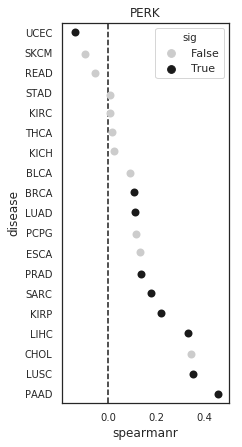

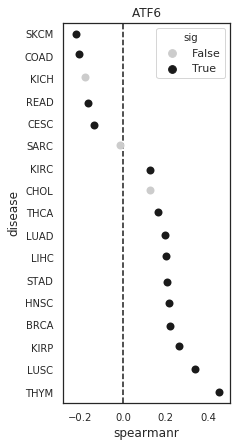

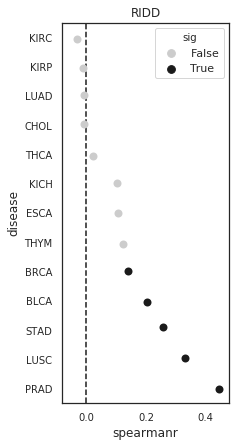

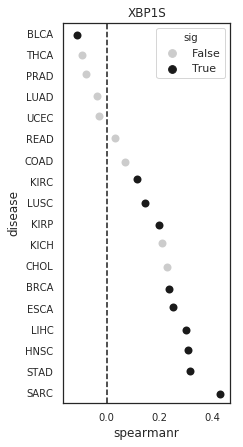

In [62]:
plotCorrelation(dfplot, "SCNA", saveFig = False, saveDir = figDir)

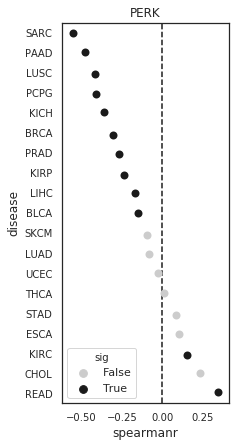

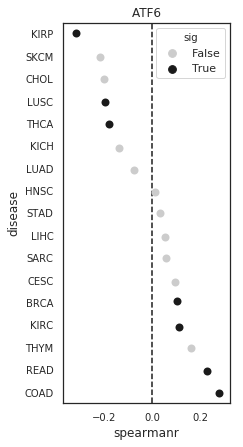

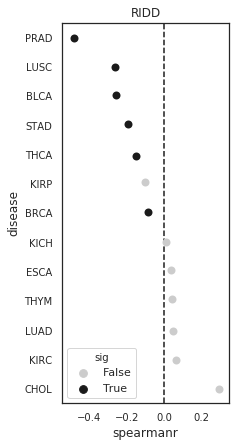

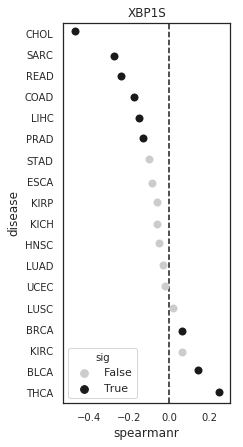

In [63]:
dfplot = pd.merge(pathwayScore,CYT, on = "patient_id")
dfplot = pd.merge(dfplot, tcgaDf[["patient_id","disease"]], on = "patient_id").drop_duplicates()
plotCorrelation(dfplot, "CYT", saveFig = False, saveDir = figDir)

# Table 1

In [64]:
import statsmodels.formula.api as sm

In [65]:
dfmodel = pd.merge(SCNADf,stage_info, on = 'patient_id').drop_duplicates()
dfmodel = pd.merge(dfmodel, tcgaDf[["patient_id","disease"]], on = "patient_id").drop_duplicates()
model = sm.ols("SCNA ~ stage + disease", data = dfmodel).fit()
model.summary()

/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SCNA   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     104.5
Date:                Sun, 12 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:20:43   Log-Likelihood:                -14608.
No. Observations:                6298   AIC:                         2.927e+04
Df Residuals:                    6270   BIC:                         2.946e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.5280      0.302     28.193      0.000       7.935       9.121
stage[T.Stage II]      0.5455      0.090      6.066      0.000       0.369       0.722
stage[T.Stage III]     0.5664      0.090      6.273      0.000       0.389       0.743
stage[T.Stage IV]      0.7908      0.118      6.717      0.000       0.560       1.022
disease[T.BLCA]       -4.4612      0.326    -13.691      0.000      -5.100      -3.822
disease[T.BRCA]       -4.3867      0.306    -14.356      0.000      -4.986      -3.788
disease[T.CESC]       -4.6771      0.364    -12.866      0.000      -5.390      -3.964
disease[T.CHOL]       -3.1985      0.512     -6.251      0.000      -4.202      -2.195
disease[T.COAD]       -4.2176      0.322    -13.081      0.000      -4.850      -3.586
disease[T.DLBC]    -9.521e-15   1.55e-15     -6.133      0.000   -1.26e-14   -6.48e-15
disease[T.ESCA]       -3.9336      0.391    -10.072      0.000      -4.699      -3.168
disease[T.GBM]      4.407e-16   1.81e-16      2.437      0.015    8.62e-17    7.95e-16
disease[T.HNSC]       -5.4280      0.324    -16.769      0.000      -6.063      -4.793
disease[T.KICH]        1.1212      0.427      2.627      0.009       0.284       1.958
disease[T.KIRC]       -5.6004      0.316    -17.708      0.000      -6.220      -4.980
disease[T.KIRP]       -3.9659      0.338    -11.716      0.000      -4.629      -3.302
disease[T.LGG]      2.448e-15   1.22e-16     20.124      0.000    2.21e-15    2.69e-15
disease[T.LIHC]       -4.1425      0.327    -12.683      0.000      -4.783      -3.502
disease[T.LUAD]       -4.3341      0.321    -13.498      0.000      -4.964      -3.705
disease[T.LUSC]       -3.6125      0.322    -11.235      0.000      -4.243      -2.982
disease[T.MESO]       -4.7768      0.402    -11.875      0.000      -5.565      -3.988
disease[T.OV]         -1.4841      0.333     -4.454      0.000      -2.137      -0.831
disease[T.PAAD]       -6.0931      0.353    -17.272      0.000      -6.785      -5.402
disease[T.PCPG]     3.179e-16   6.15e-17      5.170      0.000    1.97e-16    4.38e-16
disease[T.PRAD]    -1.276e-15   1.43e-16     -8.922      0.000   -1.56e-15   -9.96e-16
disease[T.READ]       -3.4783      0.360     -9.650      0.000      -4.185      -2.772
disease[T.SARC]     1.441e-16   4.58e-17      3.144      0.002    5.43e-17    2.34e-16
disease[T.SKCM]       -3.8357      0.516     -7.427      0.000      -4.848      -2.823
disease[T.STAD]       -5.2223      0.337    -15.498      0.000      -5.883      -4.562
disease[T.TGCT]       -2.5453      0.407     -6.249      0.000      -3.344      -1.747
disease[T.THCA]       -8.2828      0.318    -26.068      0.000      -8.906      -7.660
disease[T.THYM]             0          0        nan        nan           0           0
disease[T.UCEC]       -5.1842      0.3

In [66]:
"""Table 1, SCNA coefficient and SCNA p-values"""
table1_scna = pd.DataFrame({"coef": model.params.loc[["stage[T.Stage II]","stage[T.Stage III]","stage[T.Stage IV]"]],
                       "pval": model.pvalues.loc[["stage[T.Stage II]","stage[T.Stage III]","stage[T.Stage IV]"]]})
table1_scna

,coef,pval
stage[T.Stage II],0.545535,1.385176e-09
stage[T.Stage III],0.566367,3.770875e-10
stage[T.Stage IV],0.790802,2.011444e-11


In [67]:
dfmodel = pd.merge(CYT,stage_info, on = 'patient_id').drop_duplicates()
dfmodel = pd.merge(dfmodel, tcgaDf[["patient_id","disease"]], on = "patient_id").drop_duplicates()
model = sm.ols("CYT ~ stage + disease", data = dfmodel).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CYT   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     93.71
Date:                Sun, 12 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:20:44   Log-Likelihood:                -9598.2
No. Observations:                6458   AIC:                         1.925e+04
Df Residuals:                    6430   BIC:                         1.944e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1171      0.130      8.617      0.000       0.863       1.371
stage[T.Stage II]     -0.0686      0.039     -1.782      0.075      -0.144       0.007
stage[T.Stage III]    -0.0321      0.039     -0.829      0.407      -0.108       0.044
stage[T.Stage IV]     -0.1968      0.050     -3.899      0.000      -0.296      -0.098
disease[T.BLCA]        1.0667      0.140      7.627      0.000       0.793       1.341
disease[T.BRCA]        1.0225      0.131      7.808      0.000       0.766       1.279
disease[T.CESC]        1.9598      0.156     12.583      0.000       1.654       2.265
disease[T.CHOL]        1.1688      0.221      5.280      0.000       0.735       1.603
disease[T.COAD]        0.8400      0.137      6.121      0.000       0.571       1.109
disease[T.DLBC]    -5.254e-16   1.73e-16     -3.034      0.002   -8.65e-16   -1.86e-16
disease[T.ESCA]        1.0264      0.168      6.110      0.000       0.697       1.356
disease[T.GBM]      4.103e-16   8.01e-17      5.123      0.000    2.53e-16    5.67e-16
disease[T.HNSC]        1.8175      0.139     13.090      0.000       1.545       2.090
disease[T.KICH]        0.3830      0.184      2.078      0.038       0.022       0.744
disease[T.KIRC]        2.7301      0.136     20.148      0.000       2.464       2.996
disease[T.KIRP]        0.8302      0.146      5.705      0.000       0.545       1.115
disease[T.LGG]     -3.235e-16   5.37e-17     -6.026      0.000   -4.29e-16   -2.18e-16
disease[T.LIHC]        0.7805      0.140      5.565      0.000       0.506       1.055
disease[T.LUAD]        1.9518      0.137     14.204      0.000       1.682       2.221
disease[T.LUSC]        1.7947      0.138     13.007      0.000       1.524       2.065
disease[T.MESO]        1.8163      0.174     10.468      0.000       1.476       2.156
disease[T.OV]          0.4280      0.143      2.999      0.003       0.148       0.708
disease[T.PAAD]        1.3899      0.152      9.163      0.000       1.093       1.687
disease[T.PCPG]     6.841e-18   2.19e-17      0.312      0.755   -3.61e-17    4.98e-17
disease[T.PRAD]     1.929e-16   2.26e-17      8.555      0.000    1.49e-16    2.37e-16
disease[T.READ]        0.7843      0.155      5.059      0.000       0.480       1.088
disease[T.SARC]     2.706e-16   3.64e-17      7.432      0.000    1.99e-16    3.42e-16
disease[T.SKCM]        0.8570      0.223      3.836      0.000       0.419       1.295
disease[T.STAD]        1.5078      0.145     10.414      0.000       1.224       1.792
disease[T.TGCT]        2.3986      0.176     13.652      0.000       2.054       2.743
disease[T.THCA]        0.7076      0.136      5.189      0.000       0.440       0.975
disease[T.THYM]             0          0        nan        nan           0           0
disease[T.UCEC]        0.6841      0.1

In [68]:
"""Table 1, CYT coefficient and CYT p-values"""
table1_cyt = pd.DataFrame({"coef": model.params.loc[["stage[T.Stage II]","stage[T.Stage III]","stage[T.Stage IV]"]],
                           "pval": model.pvalues.loc[["stage[T.Stage II]","stage[T.Stage III]","stage[T.Stage IV]"]]})
table1_cyt

,coef,pval
stage[T.Stage II],-0.068647,0.074846
stage[T.Stage III],-0.032127,0.407011
stage[T.Stage IV],-0.196760,0.000097


# Table 2

In [69]:
from sklearn.preprocessing import QuantileTransformer

In [70]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
dfmodel = pd.merge(pathwayScore,SCNADf, on = "patient_id")
dfmodel = pd.merge(dfmodel, tcgaDf[["patient_id","disease"]], on = "patient_id")
dfmodel = pd.merge(CYT[["CYT","patient_id"]], dfmodel, on = "patient_id")
dfmodel[["PERK","ATF6","XBP1S","SCNA","RIDD"]] = quantile_transformer.fit_transform(dfmodel[["PERK","ATF6","XBP1S","SCNA","RIDD"]])
model = sm.ols("CYT ~ SCNA + PERK + ATF6 + XBP1S + RIDD + disease", data = dfmodel.drop_duplicates()).fit()

In [71]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CYT   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     133.7
Date:                Sun, 12 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:20:54   Log-Likelihood:                -12433.
No. Observations:                8488   AIC:                         2.492e+04
Df Residuals:                    8460   BIC:                         2.512e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.4800      0.082     30.259      0.000       2.319       2.641
disease[T.BRCA]    -0.8370      0.138     -6.074      0.000      -1.107      -0.567
disease[T.CESC]     1.1364      0.093     12.265      0.000       0.955       1.318
disease[T.CHOL]     0.1256      0.352      0.357      0.721      -0.565       0.816
disease[T.COAD]     0.0551      0.089      0.617      0.537      -0.120       0.230
disease[T.ESCA]     0.5882      0.188      3.121      0.002       0.219       0.958
disease[T.HNSC]     0.5546      0.118      4.693      0.000       0.323       0.786
disease[T.KICH]    -0.4596      0.301     -1.525      0.127      -1.050       0.131
disease[T.KIRC]     1.3185      0.243      5.428      0.000       0.842       1.795
disease[T.KIRP]    -0.5513      0.155     -3.545      0.000      -0.856      -0.246
disease[T.LIHC]    -0.5508      0.226     -2.442      0.015      -0.993      -0.109
disease[T.LUAD]     0.1702      0.119      1.432      0.152      -0.063       0.403
disease[T.LUSC]    -0.0127      0.144     -0.089      0.929      -0.294       0.269
disease[T.PAAD]     0.1896      0.101      1.872      0.061      -0.009       0.388
disease[T.PCPG]    -0.9118      0.101     -9.071      0.000      -1.109      -0.715
disease[T.PRAD]    -1.1903      0.114    -10.417      0.000      -1.414      -0.966
disease[T.READ]     0.1034      0.114      0.903      0.366      -0.121       0.328
disease[T.SARC]     0.5575      0.094      5.935      0.000       0.373       0.742
disease[T.SKCM]     0.4643      0.139      3.343      0.001       0.192       0.737
disease[T.STAD]     0.2696      0.157      1.713      0.087      -0.039       0.578
disease[T.THCA]    -1.4982      0.145    -10.324      0.000      -1.783      -1.214
disease[T.THYM]     0.7589      0.123      6.193      0.000       0.519       0.999
disease[T.UCEC]    -0.2344      0.075     -3.115      0.002      -0.382      -0.087
SCNA               -0.2997      0.013    -23.627      0.000      -0.325      -0.275
PERK               -0.3756      0.052     -7.162      0.000      -0.478      -0.273
ATF6                0.2010      0.063      3.207      0.001       0.078       0.324
XBP1S               0.0920      0.049      1.868      0.062      -0.005       0.188
RIDD               -0.1416      0.055     -2.594      0.010      -0.249      -0.035
==============================================================================
Omnibus:                      378.170   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              441.590
Skew:                           0.508   Prob(JB):                     1.29e-96
Kurtosis:                       3.466   Cond. No.                         73.1
==============================================================================

Warn

In [72]:
augmented_genes = set()
for pairs in augmented_pairs.index.tolist():
    genes = pairs.split("-")
    augmented_genes.add(genes[0])
    augmented_genes.add(genes[1])

In [73]:
"""Table S5, model without IHC"""
table2_supplementary = pd.DataFrame({"coef": model.params.loc[["SCNA","XBP1S","PERK","ATF6","RIDD"]],
                       "pval": model.pvalues.loc[["SCNA","XBP1S","PERK","ATF6","RIDD"]]})
table2_supplementary

,coef,pval
SCNA,-0.299704,1.422715e-119
XBP1S,0.091954,6.180830e-02
PERK,-0.375577,8.608950e-13
ATF6,0.200991,1.344756e-03
RIDD,-0.141577,9.500050e-03


In [74]:
purityData = pd.read_excel("/cellar/users/a53206221/Data/PQ3RO1/purityData.xlsx",skiprows=3)
purityData["patient_id"] =[ x.split("-")[2] for x in purityData["Sample ID"].tolist()]

In [75]:
dfmodel = pd.merge(pathwayScore,SCNADf, on = "patient_id")
dfmodel = pd.merge(dfmodel, tcgaDf[["patient_id","disease"]], on = "patient_id")
dfmodel = pd.merge(CYT[["CYT","patient_id"]], dfmodel, on = "patient_id")
dfmodel = pd.merge(dfmodel, purityData[["IHC","patient_id"]]).dropna(subset = ["IHC"])
dfmodel[["PERK","ATF6","XBP1S","SCNA","RIDD","IHC"]] = quantile_transformer.fit_transform(dfmodel[["PERK","ATF6","XBP1S","SCNA","RIDD","IHC"]])
model_ihc = sm.ols("CYT ~ SCNA + PERK + ATF6 + XBP1S + RIDD + IHC + disease", data = dfmodel.drop_duplicates()).fit()

In [76]:
model_ihc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CYT   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     172.0
Date:                Sun, 12 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:20:57   Log-Likelihood:                -11348.
No. Observations:                7802   AIC:                         2.274e+04
Df Residuals:                    7780   BIC:                         2.289e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.6771      0.268     10.000      0.000       2.152       3.202
disease[T.BRCA]    -0.9769      0.291     -3.356      0.001      -1.547      -0.406
disease[T.CESC]     0.9900      0.084     11.839      0.000       0.826       1.154
disease[T.COAD]    -0.0751      0.077     -0.978      0.328      -0.226       0.075
disease[T.HNSC]     0.3427      0.112      3.072      0.002       0.124       0.561
disease[T.KICH]    -0.5200      0.454     -1.145      0.252      -1.410       0.370
disease[T.KIRC]     1.1683      0.407      2.869      0.004       0.370       1.966
disease[T.KIRP]    -0.4748      0.318     -1.494      0.135      -1.098       0.148
disease[T.LIHC]    -0.8068      0.215     -3.752      0.000      -1.228      -0.385
disease[T.LUAD]     0.0706      0.300      0.236      0.814      -0.517       0.658
disease[T.LUSC]     0.0254      0.321      0.079      0.937      -0.604       0.655
disease[T.PRAD]    -1.2241      0.299     -4.093      0.000      -1.810      -0.638
disease[T.READ]    -0.0532      0.106     -0.503      0.615      -0.261       0.154
disease[T.SKCM]     0.3505      0.128      2.732      0.006       0.099       0.602
disease[T.THCA]    -1.2890      0.291     -4.427      0.000      -1.860      -0.718
disease[T.UCEC]    -0.3091      0.066     -4.707      0.000      -0.438      -0.180
SCNA               -0.3024      0.013    -23.564      0.000      -0.328      -0.277
PERK               -0.2736      0.044     -6.278      0.000      -0.359      -0.188
ATF6                0.2378      0.056      4.238      0.000       0.128       0.348
XBP1S               0.0638      0.044      1.443      0.149      -0.023       0.150
RIDD               -0.0351      0.049     -0.720      0.471      -0.131       0.060
IHC                -0.0936      0.011     -8.347      0.000      -0.116      -0.072
==============================================================================
Omnibus:                      373.192   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.719
Skew:                           0.530   Prob(JB):                     5.41e-96
Kurtosis:                       3.475   Cond. No.                         279.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
"""Table 2, model with IHC"""
table2 = pd.DataFrame({"coef": model_ihc.params.loc[["SCNA","XBP1S","PERK","ATF6","RIDD","IHC"]],
                       "pval": model_ihc.pvalues.loc[["SCNA","XBP1S","PERK","ATF6","RIDD","IHC"]]})
table2

,coef,pval
SCNA,-0.302434,1.190499e-118
XBP1S,0.063774,1.490671e-01
PERK,-0.273591,3.613854e-10
ATF6,0.237756,2.281763e-05
RIDD,-0.035104,4.714897e-01
IHC,-0.093614,8.226430e-17
